In [1]:
import sys
import os
import json
sys.path.append("../") # go to parent dir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr 


from nsm_toolbox.src import network_diffusion_model, FKPP_model
from nsm_toolbox.src.find_optimal_timepoint import find_optimal_timepoint
from nsm_toolbox.src.ModelSelection import ModelSelection

from my_src import utils
from my_src import constants
from my_src.clinical_group import ClinicalGroup


%load_ext autoreload
%autoreload 2

figures_folder = "../writeup/figures/"

In [2]:
# load in target data
tau = pd.read_csv("../data/PET/tau_ab+_tau+.csv", names=["region", "suvr"], header=0)
target_data = tau["suvr"].values

# remove the subcortical regions, since these are affected by off-target binding of the tau-PET tracer
CORT_IDX = np.concatenate([np.arange(34), np.arange(49, 83)])
target_data = target_data[CORT_IDX]
target_data = utils.normalise_data(target_data)

In [3]:
model_names = ["NDM", "FKPP", "WFKPP"]
aic_degree_freedom = [2, 3, 3]
aic_results = []
participants = list(range(42)) + ["avg"]
for clinical_group_name in constants.clinical_group_names:
    for participant in participants:
        residuals = []
        included_models = []
        dof = []
        for i, model in enumerate(model_names):
            try:
                prediction = np.load(constants.prediction_filepath.format(model=model, clinical_group_name=clinical_group_name, participant=participant))
                residual = prediction - target_data
                residuals.append(residual)
                included_models.append(model)
                dof.append(aic_degree_freedom[i])
            except FileNotFoundError:
                print(f"File not found for {model} in {clinical_group_name} for participant {participant}")
                

        residuals = np.array(residuals).T
        clinical_group_result = ModelSelection(dof, 'AICc', model_names=included_models, plot=False)(residuals)
        clinical_group_result["clinical_group_name"] = clinical_group_name
        clinical_group_result["participant"] = participant
        aic_results.append(clinical_group_result)
aic_results = pd.concat(aic_results, axis=0)

In [4]:
optimal_parameters = []
for model in model_names:
    print(model)
    with open(constants.optimal_parameters_filepath.format(model=model), "r") as f:
        model_params = pd.DataFrame(json.load(f))
        model_params["Model"] = model
        optimal_parameters.append(model_params)
optimal_parameters = pd.concat(optimal_parameters)
# optimal_parameters_avg_connectome = optimal_parameters[optimal_parameters["participant"] == "avg"]

NDM
FKPP
WFKPP


/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_23892/1511645954.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  optimal_parameters = pd.concat(optimal_parameters)


In [5]:
# join optimal parameters with AIC results by clinical group and model 
model_selection_df = aic_results.merge(optimal_parameters, on=["clinical_group_name", "Model","participant"], how="left")
columns = ["clinical_group_name", "Model", "participant", "AICc", "AICc weights", "r", "SSE", "seed_region", "alpha"]
model_selection_df = model_selection_df[columns]
model_selection_df = model_selection_df.rename(columns={"clinical_group_name": "Clinical Group", "Model": "Model", "participant":"Participant", "r": "Pearson's r", "SSE": "SSE", "seed_region": "Seed region"})

In [ ]:
df = model_selection_df[model_selection_df["Participant"] == "avg"]
df[["Clinical Group", "Model", "Seed region", "alpha",  "SSE","Pearson's r"]]

,Clinical Group,Model,Seed region,SSE,alpha,Pearson's r
126,CN,NDM,Inferiortemporal,2.483738,NaN,0.724365
127,CN,FKPP,Inferiortemporal,2.253801,0.463395,0.666533
128,CN,WFKPP,Entorhinal,1.855330,0.418880,0.720293
255,EMCI,NDM,Inferiortemporal,2.531589,NaN,0.718787
256,EMCI,FKPP,Inferiortemporal,2.296470,0.448311,0.663136
257,EMCI,WFKPP,Entorhinal,1.883986,0.432529,0.713494
384,LMCI,NDM,Inferiortemporal,2.618450,NaN,0.718020
385,LMCI,FKPP,Inferiortemporal,2.331756,0.466758,0.653765
386,LMCI,WFKPP,Entorhinal,1.931284,0.419243,0.708901
513,DEM,NDM,Inferiortemporal,2.564792,NaN,0.714331


/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_23892/2487260678.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_23892/2487260678.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_23892/2487260678.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_23892/2487260678.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels([


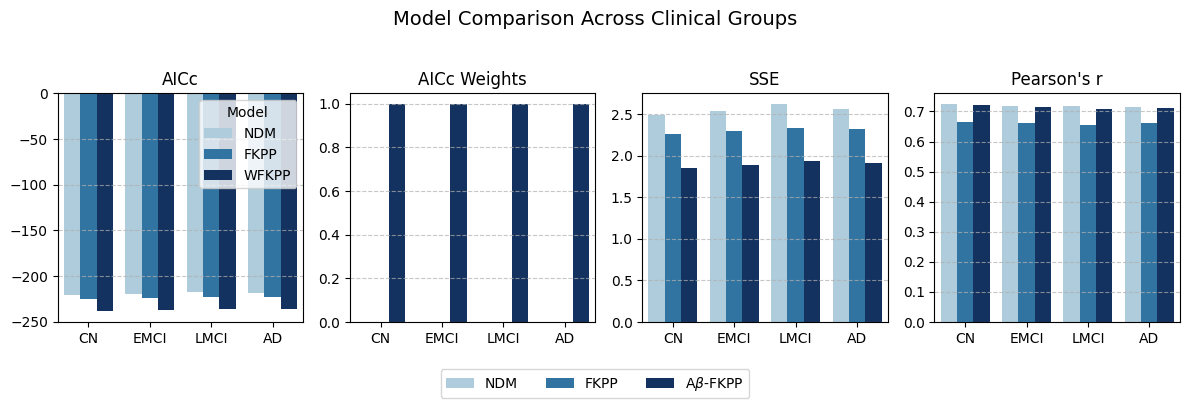

In [14]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Example assumes you have model_selection_df and constants already imported
# and that model_selection_df["Participant"] == "avg" is valid

df = model_selection_df[model_selection_df["Participant"] == "avg"]
model_palette = constants.model_colors_map

# Create a single row with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 4))  # Adjust figsize as needed
ax1, ax2, ax3, ax4 = axes

# 1. Grouped bar chart for AICc
sns.barplot(x='Clinical Group', y='AICc', hue='Model',
            data=df, palette=model_palette, ax=ax1)
ax1.set_title('AICc', fontsize=12)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', labelsize=10)
# Map xtick labels for clinical groups
ax1.set_xticklabels([
    constants.clinical_group_name_map.get(lbl.get_text(), lbl.get_text()) 
    for lbl in ax1.get_xticklabels()
])

# 2. Grouped bar chart for AICc weights
sns.barplot(x='Clinical Group', y='AICc weights', hue='Model',
            data=df, palette=model_palette, ax=ax2, legend=False)
ax2.set_title('AICc Weights', fontsize=12)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', labelsize=10)
ax2.set_xticklabels([
    constants.clinical_group_name_map.get(lbl.get_text(), lbl.get_text()) 
    for lbl in ax2.get_xticklabels()
])

# 3. Grouped bar chart for SSE
sns.barplot(x='Clinical Group', y='SSE', hue='Model',
            data=df, palette=model_palette, ax=ax3, legend=False)
ax3.set_title('SSE', fontsize=12)
ax3.set_ylabel('')
ax3.set_xlabel('')
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.tick_params(axis='both', labelsize=10)
ax3.set_xticklabels([
    constants.clinical_group_name_map.get(lbl.get_text(), lbl.get_text()) 
    for lbl in ax3.get_xticklabels()
])

# 4. Grouped bar chart for Pearson's r
sns.barplot(x='Clinical Group', y="Pearson's r", hue='Model',
            data=df, palette=model_palette, ax=ax4, legend=False)
ax4.set_title("Pearson's r", fontsize=12)
ax4.set_ylabel('')
ax4.set_xlabel('')
ax4.grid(axis='y', linestyle='--', alpha=0.7)
ax4.tick_params(axis='both', labelsize=10)
ax4.set_xticklabels([
    constants.clinical_group_name_map.get(lbl.get_text(), lbl.get_text()) 
    for lbl in ax4.get_xticklabels()
])

# Add a single legend at the bottom
handles, labels = ax1.get_legend_handles_labels()
new_labels = [constants.model_name_map.get(label, label) for label in labels]
fig.legend(handles, new_labels, loc='lower center', ncol=len(new_labels), fontsize=10)

# Title and layout adjustments
plt.suptitle('Model Comparison Across Clinical Groups', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Space for title at top
plt.subplots_adjust(bottom=0.20)        # Space for legend at bottom

# Save and show
plt.savefig(os.path.join(constants.figures_folder, 'model_comparison.pdf'),
            dpi=300, bbox_inches='tight')
plt.show()


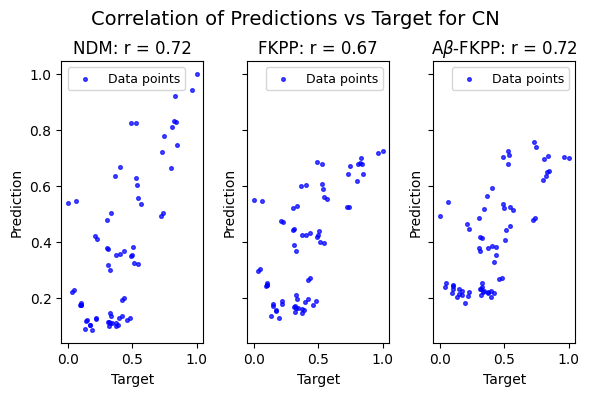

In [203]:
clinical_group_name = "CN"
model_names = ["NDM", "FKPP","WFKPP"]
aic_degree_freedom = [2, 3, 3]
residuals = []
predictions = []
targets = []
r_values = []

for model in model_names:
    prediction = np.load(constants.prediction_filepath.format(model=model, clinical_group_name=clinical_group_name, participant="avg"))
    residual = prediction - target_data
    predictions.append(prediction)
    targets.append(target_data)
    residuals.append(residual)
    # Calculate Pearson's r
    r, _ = pearsonr(target_data, prediction)
    r_values.append(r)

residuals = np.array(residuals).T

num_models = len(model_names)
fig, axes = plt.subplots(1, num_models, figsize=(6, 4), sharex=True, sharey=True)

for i, model in enumerate(model_names):
    ax = axes[i]
    # Scatter plot: target data on x-axis, prediction on y-axis
    ax.scatter(targets[i], predictions[i], alpha=0.7, color='blue', label='Data points', s=7)
    ax.set_xlabel('Target', fontsize=10)
    ax.set_ylabel('Prediction', fontsize=10)
    ax.set_title(f"{constants.model_name_map[model]}: r = {r_values[i].round(2)}", fontsize=12)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.suptitle(f"Correlation of Predictions vs Target for {constants.clinical_group_name_map[clinical_group_name]}", fontsize=14)
plt.subplots_adjust(top=0.85)  # Adjust top to make room for the title
plt.savefig(os.path.join(constants.figures_folder, 'correlation_prediction_vs_target_cn.pdf'), dpi=300, bbox_inches='tight')
plt.show()

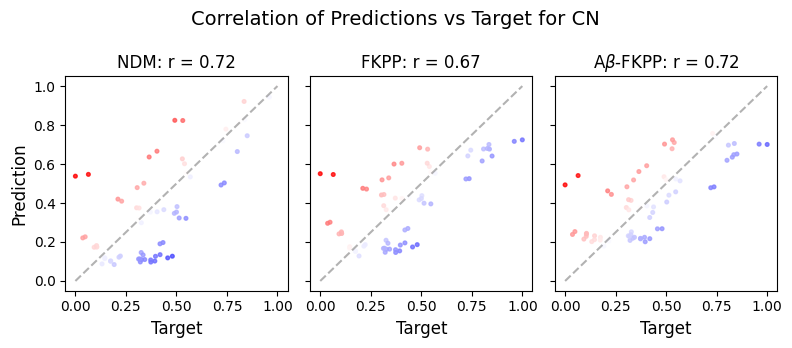

In [12]:
def create_correlation_subplots(predictions, targets, model_names, clinical_group_name, save_path=None):
    """
    Create scatter plots showing correlation between predictions and targets.
    
    Args:
        predictions: List of prediction arrays, one per model.
        targets: List of target arrays, one per model.
        model_names: List of model names.
        clinical_group_name: Clinical group name.
        save_path: File path to save the figure (optional).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    from scipy.stats import pearsonr
    from matplotlib.colors import LinearSegmentedColormap
    
    # Custom diverging colormap for residuals.
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"])
    
    n_models = len(model_names)
    # Create a single row of scatter plots
    fig, axs = plt.subplots(1, n_models, figsize=(8, 3.5), sharex=True, sharey=True)
    
    # Ensure axs is an array even if there is 1 column.
    if n_models == 1:
        axs = np.array([axs])
    
    # Scatter plots
    for i, model in enumerate(model_names):
        ax = axs[i]
        # Compute residuals.
        resid = predictions[i] - targets[i]
        r, _ = pearsonr(targets[i], predictions[i])
        # Scatter plot with residual-based color.
        ax.scatter(targets[i], predictions[i], c=resid, cmap=cmap,
                   alpha=0.8, s=7, vmin=-0.5, vmax=0.5)
        # Identity line.
        lo = min(min(targets[i]), min(predictions[i]))
        hi = max(max(targets[i]), max(predictions[i]))
        ax.plot([lo, hi], [lo, hi], 'k--', alpha=0.3)
        # Labels and title.
        ax.set_xlabel("Target", fontsize=12)
        if i == 0:
            ax.set_ylabel("Prediction", fontsize=12)
        ax.set_title(f"{constants.model_name_map.get(model, model)}: r = {r:.2f}", fontsize=12)
    
    plt.suptitle(f"Correlation of Predictions vs Target for {constants.clinical_group_name_map.get(clinical_group_name, clinical_group_name)}", 
                fontsize=14, y=0.98)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    return fig, axs

# Example usage:
clinical_group_name = "CN"
model_names = ["NDM", "FKPP", "WFKPP"]
predictions = []
targets = []

for model in model_names:
    prediction = np.load(constants.prediction_filepath.format(model=model, clinical_group_name=clinical_group_name, participant="avg"))
    predictions.append(prediction)
    targets.append(target_data)

# Note the function name change to reflect removal of tables
fig, axs = create_correlation_subplots(
    predictions,
    targets,
    model_names,
    clinical_group_name,
    save_path=os.path.join(constants.figures_folder, "correlation_prediction_vs_target_cn.pdf")
)

plt.show()

In [204]:
individuals_model_selection_df = model_selection_df[model_selection_df["Participant"] != "avg"]
individuals_model_selection_df.dtypes

Clinical Group     object
Model              object
Participant        object
AICc              float64
AICc weights      float64
Pearson's r       float64
SSE               float64
Seed region        object
alpha             float64
dtype: object

/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_43716/369670445.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y=metric, data=group_df, palette=constants.model_colors_map, ax=ax)
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_43716/369670445.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y=metric, data=group_df, palette=constants.model_colors_map, ax=ax)
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_43716/369670445.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Mo

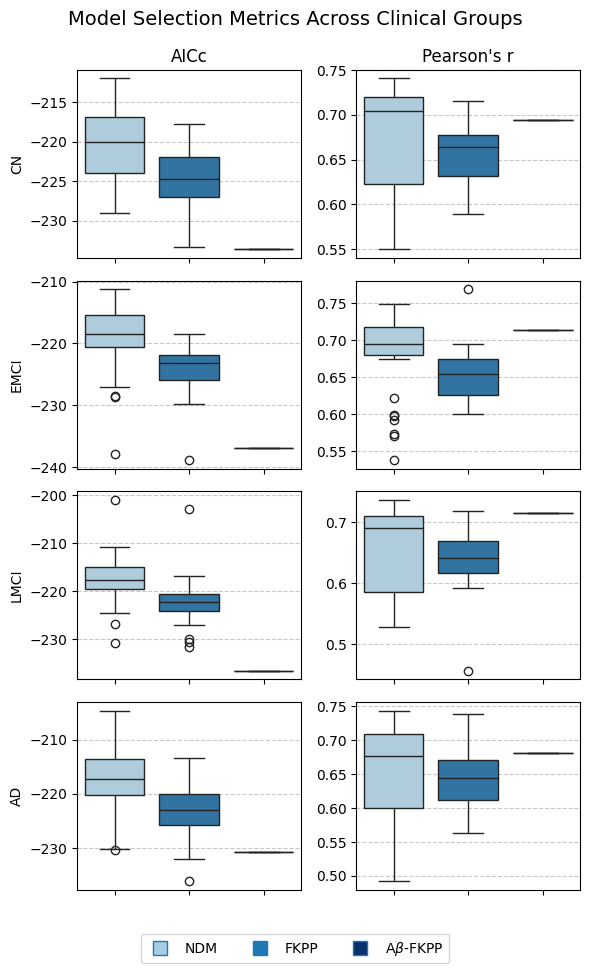

In [266]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from my_src import constants  # ensure this imports clinical_group_name_map, model_name_map, clinical_group_names, model_colors_map, figures_folder

# Filter the dataframe to include only non-average participants
df = individuals_model_selection_df[individuals_model_selection_df["Participant"] != "avg"]

# Define metrics to plot (each column) and the clinical groups (each row)
metrics = ["AICc", "Pearson's r"]
n_cols = len(metrics)
clinical_groups = constants.clinical_group_names  # e.g., ['CN', 'EMCI', 'LMCI', 'DEM']
n_rows = len(clinical_groups)

# Create a grid: each row is one clinical group, each column one metric
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 10), sharex=True)

# Loop over each clinical group (row) and metric (column)
for row, group in enumerate(clinical_groups):
    group_df = df[df["Clinical Group"] == group]
    for col, metric in enumerate(metrics):
        ax = axes[row, col] if n_rows > 1 else axes[col]
        sns.boxplot(x="Model", y=metric, data=group_df, palette=constants.model_colors_map, ax=ax)
        
        # For the top row, use the metric name as the subplot title.
        if row == 0:
            ax.set_title(metric, fontsize=12)
        
        # For the left column, set the y-label using the clinical group mapping.
        if col == 0:
            ax.set_ylabel(constants.clinical_group_name_map.get(group, group), fontsize=10)
        else:
            ax.set_ylabel("")
        
        # Remove x-axis label text for clarity.
        ax.set_xlabel("")
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.tick_params(axis="both", labelsize=10)
        
        # Update x-tick categories using model mapping
        ax.set_xticklabels([constants.model_name_map.get(lbl.get_text(), lbl.get_text()) 
                            for lbl in ax.get_xticklabels()])

# Create custom legend handles for the models.
# Ensure that your model list is in the desired order.
model_list = list(constants.model_colors_map.keys())
legend_handles = [
    Line2D([], [], marker='s', linestyle='', markersize=10, 
           markerfacecolor=constants.model_colors_map[m], 
           label=constants.model_name_map.get(m, m))
    for m in model_list
]

# Create a single global legend at the bottom.
fig.legend(legend_handles, [h.get_label() for h in legend_handles], 
           loc='lower center', ncol=len(legend_handles), fontsize=10, bbox_to_anchor=(0.5, 0.02))

plt.suptitle("Model Selection Metrics Across Clinical Groups", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(top=0.92, bottom=0.1)

plt.savefig(os.path.join(constants.figures_folder, 'individual_model_selection_metrics_by_group.pdf'),
            dpi=300, bbox_inches='tight')
plt.show()

In [249]:
import pandas as pd
import numpy as np

# Separate the average rows and individual participant rows
df_avg = model_selection_df[model_selection_df["Participant"] == "avg"]
df_ind = model_selection_df[model_selection_df["Participant"] != "avg"]

# Define functions to calculate the 95% percentile range
def percentile_range_lower(x):
    return np.nanpercentile(x, 2.5)

def percentile_range_upper(x):
    return np.nanpercentile(x, 97.5)

def percentile_range_width(x):
    upper = np.nanpercentile(x, 97.5)
    lower = np.nanpercentile(x, 2.5)
    return upper - lower

# For individual participants, group by Clinical Group and Model
# Compute mean and 95% percentile range width (upper - lower)
grouped = df_ind.groupby(["Clinical Group", "Model"]).agg(
    SSE_ind_mu=("SSE", "mean"),
    SSE_ind_width=("SSE", percentile_range_width),
    r_ind_mu=("Pearson's r", "mean"),
    r_ind_width=("Pearson's r", percentile_range_width)
).reset_index()

# Select average metrics from df_avg
df_avg = df_avg[["Clinical Group", "Model", "SSE", "Pearson's r"]].rename(columns={
    "SSE": "SSE_Avg",
    "Pearson's r": "r_Avg"
})

# Merge the average and individual metrics
merged_df = pd.merge(df_avg, grouped, on=["Clinical Group", "Model"], how="left")

# Compute percent differences
merged_df["% diff SSE"] = ((merged_df["SSE_ind_mu"] - merged_df["SSE_Avg"]) / merged_df["SSE_ind_mu"]) * 100
merged_df["% diff r"] = ((merged_df["r_ind_mu"] - merged_df["r_Avg"]) / merged_df["r_ind_mu"]) * 100

# Define new column names mapping
column_names = {
    "SSE_Avg": "SSE Avg",
    "SSE_ind_mu": "SSE Individual μ",
    "% diff SSE": "% diff SSE",
    "SSE_ind_width": "SSE 95% Range",
    "r_Avg": "r Avg",
    "r_ind_mu": "r Individual μ",
    "% diff r": "% diff r",
    "r_ind_width": "r 95% Range"
}

# Rename and reorder columns
merged_df = merged_df.rename(columns=column_names)
final_columns = ["Clinical Group", "Model", 
                "SSE Avg", "SSE Individual μ", "% diff SSE", "SSE 95% Range",
                "r Avg", "r Individual μ", "% diff r", "r 95% Range"]
merged_df = merged_df[final_columns]

# Apply rounding for numeric columns
merged_df["SSE Avg"] = merged_df["SSE Avg"].round(2)
merged_df["SSE Individual μ"] = merged_df["SSE Individual μ"].round(2)
merged_df["% diff SSE"] = merged_df["% diff SSE"].round(2)
merged_df["SSE 95% Range"] = merged_df["SSE 95% Range"].round(3)
merged_df["r Avg"] = merged_df["r Avg"].round(3)
merged_df["r Individual μ"] = merged_df["r Individual μ"].round(3)
merged_df["% diff r"] = merged_df["% diff r"].round(2)
merged_df["r 95% Range"] = merged_df["r 95% Range"].round(3)

# Apply clinical group and model name mappings
merged_df["Clinical Group"] = merged_df["Clinical Group"].map(constants.clinical_group_name_map)
merged_df["Model"] = merged_df["Model"].map(constants.model_name_map)

merged_df

,Clinical Group,Model,SSE Avg,SSE Individual μ,% diff SSE,SSE 95% Range,r Avg,r Individual μ,% diff r,r 95% Range
0,CN,NDM,2.48,2.50,0.64,0.555,0.724,0.677,-6.97,0.168
1,CN,FKPP,2.25,2.26,0.45,0.352,0.667,0.655,-1.69,0.091
2,CN,A$\beta$-FKPP,1.86,1.90,2.14,0.394,0.720,0.718,-0.36,0.151
3,EMCI,NDM,2.53,2.56,1.04,0.630,0.719,0.686,-4.80,0.174
4,EMCI,FKPP,2.30,2.29,-0.36,0.348,0.663,0.654,-1.36,0.091
5,EMCI,A$\beta$-FKPP,1.88,1.92,1.90,0.453,0.713,0.715,0.20,0.113
6,LMCI,NDM,2.62,2.60,-0.53,0.604,0.718,0.654,-9.76,0.174
7,LMCI,FKPP,2.33,2.35,0.83,0.468,0.654,0.641,-2.03,0.110
8,LMCI,A$\beta$-FKPP,1.93,1.96,1.44,0.662,0.709,0.706,-0.43,0.141
9,AD,NDM,2.56,2.61,1.87,0.809,0.714,0.656,-8.97,0.231


In [207]:
column_names.values()

dict_values(['AICc Avg', 'AICc Individual μ', '% diff AICc', 'AICc Individual σ', 'r Avg', 'r Individual μ', '% diff r', 'r Individual σ'])

In [123]:
iteration_results = []
for group in constants.clinical_group_names: 
    for participant in range(10):
        cg_participant_df = pd.read_csv(constants.optimization_iters_filepath.format(model="FKPP", clinical_group_name=group, participant=participant), header=0)
        cg_participant_df["clinical_group_name"] = group
        cg_participant_df["participant"] = participant
        iteration_results.append(cg_participant_df)
    cg_participant_df = pd.read_csv(constants.optimization_iters_filepath.format(model="FKPP", clinical_group_name=group, participant="average"), header=0)
    cg_participant_df["clinical_group_name"] = group
    cg_participant_df["participant"] = "average"
    iteration_results.append(cg_participant_df)
iteration_results = pd.concat(iteration_results)
node_count_df = iteration_results.groupby(["clinical_group_name", "participant","node"]).func_vals.min().reset_index()
node_count_df.participant.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'average'], dtype=object)

In [197]:
# open optimal parameters json 
with open(constants.optimal_parameters_filepath.format(model="WFKPP"), "r") as f:
    optimal_parameters = json.load(f)
optimal_parameters = pd.DataFrame(optimal_parameters)
optimal_parameters.seed_region.unique()

array(['Inferiortemporal', 'Entorhinal', 'Amygdala', 'Temporalpole'],
      dtype=object)

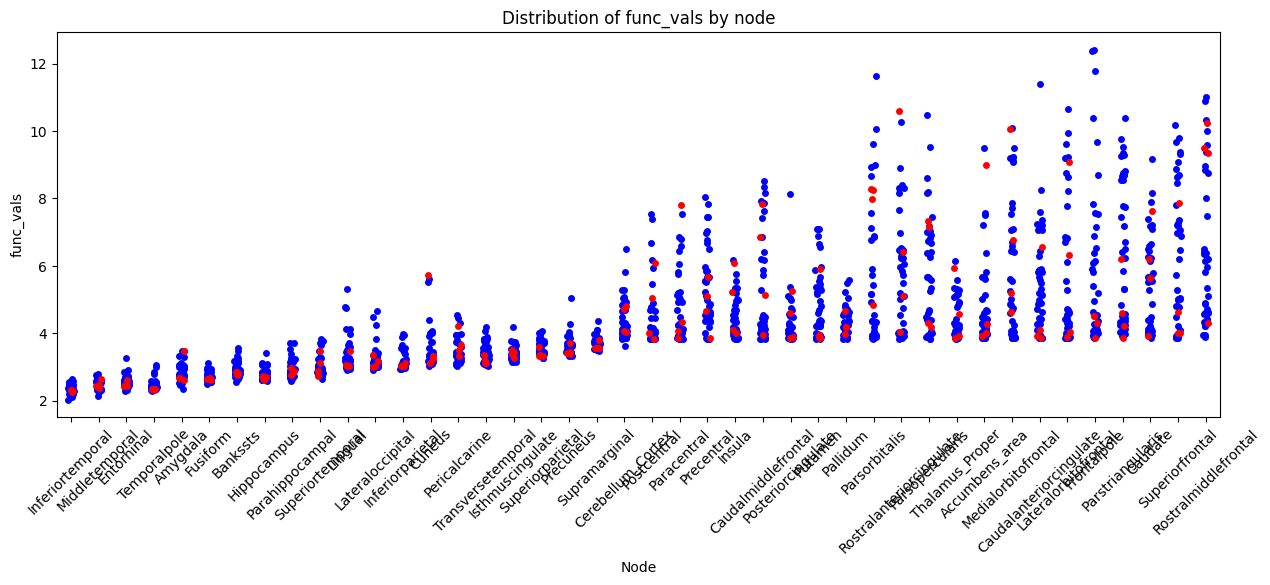

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume node_count_df is your dataframe
# Sort nodes by the minimum func_vals achieved by each node
order = node_count_df.groupby('node')['func_vals'].min().sort_values().index.tolist()

# Separate the "average" group from others for different coloring
non_avg = node_count_df[node_count_df['participant'] != 'average']
avg = node_count_df[node_count_df['participant'] == 'average']

plt.figure(figsize=(15, 5))

# Plot non-average groups in blue
sns.stripplot(data=non_avg, x='node', y='func_vals', order=order,
              jitter=True, color='blue')

# Plot "average" group in red
sns.stripplot(data=avg, x='node', y='func_vals', order=order,
              jitter=True, color='red')

# Calculate and annotate the mean func_vals for each node
means = node_count_df.groupby('node')['func_vals'].mean()
# for i, node in enumerate(order):
#     plt.text(i, means[node], f"{means[node]:.2f}", color='black',
#              ha='center', va='bottom', fontsize=9)

plt.title('Distribution of func_vals by node')
plt.xlabel('Node')
plt.ylabel('func_vals')
plt.xticks(rotation=45)
plt.show()

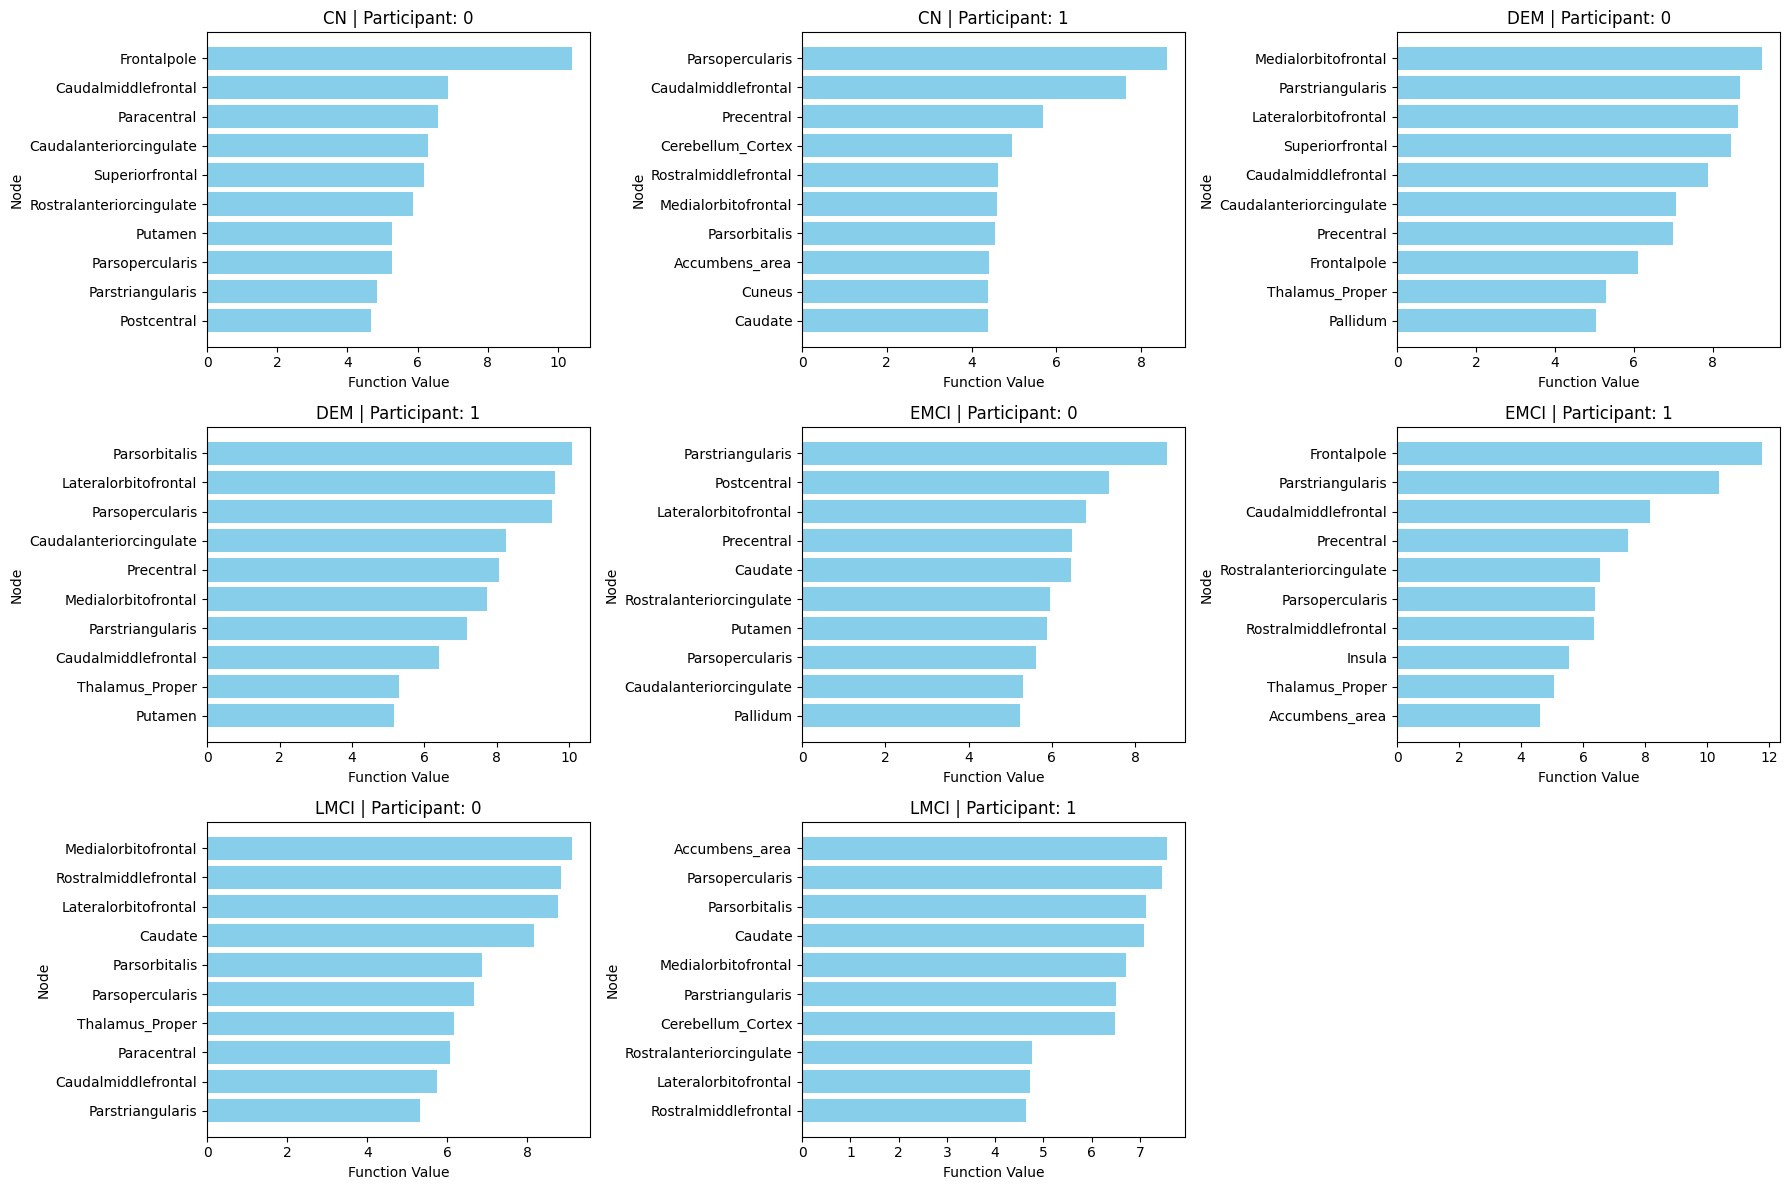

In [108]:
import matplotlib.pyplot as plt
import math

def plot_top_nodes(node_count_df):
    """
    Plot horizontal bar plots for the top 10 highest counted nodes
    for each (clinical_group_name, participant) combination.

    Parameters:
      node_count_df: DataFrame with columns ['clinical_group_name','participant','node','count'].
    """
    # Get unique group combinations
    unique_groups = node_count_df[['clinical_group_name', 'participant']].drop_duplicates()
    n_groups = len(unique_groups)
    
    # Determine grid size (we display up to 3 columns)
    n_cols = min(3, n_groups)
    n_rows = math.ceil(n_groups / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows), squeeze=False)
    
    # Iterate over each combination and plot top 10 nodes
    for idx, (_, group_row) in enumerate(unique_groups.iterrows()):
        cg = group_row['clinical_group_name']
        part = group_row['participant']
        
        # Filter for this group & sort descending by count; take top 10
        subset = node_count_df[(node_count_df['clinical_group_name']==cg) & (node_count_df['participant']==part)]
        subset = subset.sort_values('func_vals', ascending=False).head(10)
        
        # For a horizontal bar chart, reverse the order so highest is on top
        subset = subset.sort_values('func_vals', ascending=True)
        
        ax = axes[idx // n_cols][idx % n_cols]
        ax.barh(subset['node'], subset['func_vals'], color='skyblue')
        ax.set_title(f"{cg} | Participant: {part}", fontsize=12)
        ax.set_xlabel("Function Value")
        ax.set_ylabel("Node")
    
    # Hide extra subplots if any
    for j in range(idx+1, n_rows*n_cols):
        axes[j // n_cols][j % n_cols].axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Example usage:
# Assuming 'node_count_df' is defined as:
# node_count_df = iteration_results.groupby(["clinical_group_name", "participant","node"]) \
#                 .alpha.count().reset_index().rename(columns={"alpha": "count"})
plot_top_nodes(node_count_df)

In [ ]:
fkpp_results = []
for clinical_group_name in constants.clinical_group_names:
    average_connectome_path = constants.average_connectome_path.format(clinical_group_name = clinical_group_name)
    model = FKPP_model.FKPP(connectome_fname=average_connectome_path, # set up our network diffusion model class with the connectome, timepoints, gamma, and reference list
                                  t=t,
                                  gamma = gamma,
                                  ref_list=region_list,
                                  )
    df, optimal_parameters = model.optimise_fkpp(target_data)
    model.seed_region = optimal_parameters["seed"]
    model.alpha = optimal_parameters["alpha"]
    model_output = model.run_FKPP()
    min_idx, prediction, SSE = find_optimal_timepoint(model_output, target_data)
    r = pearsonr(prediction, target_data)[0]
    fkpp_results.append(dict(
        clinical_group_name = clinical_group_name,
        seed_region = model.seed_region,
        r = r
    ))

fkpp_results = pd.DataFrame(fkpp_results)
fkpp_results

,clinical_group_name,seed_region,r
0,CN,Inferiortemporal,0.692583
1,EMCI,Inferiortemporal,0.663057
2,LMCI,Inferiortemporal,0.646245
3,DEM,Inferiortemporal,0.619568
